In [1]:
import nltk
from nltk import corpus
from nltk.collocations import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import wordnet
from nltk import punkt
from nltk.util import ngrams
from nltk import FreqDist

import re
from bs4 import BeautifulSoup
import unicodedata
from six import iteritems
from string import punctuation
from collections import Counter
import numpy as np
import calendar

In [2]:
import gensim
from gensim import corpora, models
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.similarities.docsim import MatrixSimilarity

import pandas as pd
from datetime import datetime

#Importing sklearn for bigram finder
from sklearn.feature_extraction.text import CountVectorizer

C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

%matplotlib inline


## Import and Clean Connect Report

In [4]:
report=pd.read_csv('updated_connect_report.csv')

#trandforming the Date column in to pandas dates
report['Created Date']=pd.to_datetime(report['Created Date'])

#removing null records
report=report[pd.notnull(report['Created Date'])]
report=report[pd.notnull(report['Body'])]

#Removing HTML tags and codes
report['Body'] = report['Body'].apply(lambda x:BeautifulSoup(x))
report['Body'] = report['Body'].apply(lambda x:x.get_text())

#Removing tags/mentions
report['Body'] = report['Body'].apply(lambda x:re.sub('{@[\w\d]*}', '',x))

#Removing urls
report['Body'] = report['Body'].apply(lambda x:re.sub(r'^https?:\/\/.*[\r\n]*', '', x,flags=re.MULTILINE))

#Removing weird unicode characters
report['Body'] = report['Body'].apply(lambda x: x.encode('ascii', 'ignore'))

C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\bs4\__init__.py:181: UserWarning:

No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")




## Report Generator

In [7]:
final_report=pd.DataFrame

#Use this function to create the final report for analysis
# Directions:
# 1. Set Group to a list of group names, a single name of a group, or All to use all groups
# 2. Set Type to a specific Feed Item Type or All
# 3. Set Start Date or leave blank(defaults to: 1/1/2017)
# 4. Set End Date or leave blank(defaults to: Today's date)

def report_generator(Group,Type,Date_start=pd.to_datetime("2017-01-01"),Date_finish=pd.to_datetime('today')):
    if type(Group) == list:
        final_report=report.loc[report['Name'].isin(Group)] 
    elif (Group=='All'):
        final_report=report
    else:
        final_report=report.loc[report['Name']==Group]
                                
    if (Type=='All'):
        final_report=final_report
    else:
        final_report=final_report.loc[final_report['Feed Item Type']==Type]
    
    if(Date_start=="2017-01-01" and Date_finish== pd.to_datetime('today')):
        final_report=final_report
    else:
        Date_start=pd.to_datetime(Date_start, utc=False)
        Date_finish=pd.to_datetime(Date_finish, utc=False)
        final_report=final_report[(final_report['Created Date'] > Date_start) & (final_report['Created Date']< Date_finish)]   
    return(final_report)


final_report=report_generator(['CPC+ All','NLT Internal Users'],'All',"2018-01-01","2018-04-06")

#sample final report
final_report.head(5)

,Network: Name,Name,Created By: Full Name,Created By: Company Name,Body,Created Date,Like Count,Comment Count,Feed Item Type
6,CPC Plus Connect,CPC+ All,Walker Sands,Booz Allen Hamilton,"CPC+ PRACTICE PORTAL OUTAGE ALERT: Today, Thur...",2018-04-05,2.0,0.0,Text Post
7,CPC Plus Connect,CPC+ All,Angela Oiler,OH,Our practice has not yet received an email reg...,2018-04-05,1.0,3.0,Text Post
8,CPC Plus Connect,CPC+ All,Brian Litz,CapitalCare Family Practice Ravena,Hi All! Would someone kindly clarify how the p...,2018-04-05,1.0,2.0,Text Post
9,CPC Plus Connect,CPC+ All,Paula Manning,Premier Health Associates,When running our continuity of care reporting ...,2018-04-05,1.0,10.0,Text Post
10,CPC Plus Connect,CPC+ All,Jennifer Rodrigues,Robert Wood Johnson Medical Group/Family Medicine,I need some help in clarifying the ECQM Pneumo...,2018-04-05,0.0,2.0,Text Post


## Tokenizer Function

In [49]:
##Stop word and lemmatizer creation (PLEASE add to stop where you see fit)
stop = stopwords.words('english')
stop.append("cpc+")
stop.append("hi")
stop.append("hello")
stop.append("also")
stop.append("anyone")
stop.append("et")
stop.append("please")
stop.append("would")
stop.append("should")
stop.append("would")
stop.append("march")
stop.append("february")
stop.append("everyone")
stop.append("join")
stop.append("need")
stop.append("check")
stop.append("click")
stop.append("u")
stop.append("thursday")
stop.append("ellen")
stop.append("april")
stop.append("friday")
stop.append("currently")
stop.append("regarding")
stop.append("thank")
stop.append("session")
stop.append("pm")

wnl = WordNetLemmatizer() 

In [14]:
#this function tokenizes text (single and bigrams), removes stop word and punctuation, and lemmatizes the tokens
def tokenizer(text, extend_bigrams = True):
 
    tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text.lower())]
    
    tokens = []
    
    for token_by_sent in tokens_:
        tokens += token_by_sent
 
    tokens = list(filter(lambda t: t not in stop, tokens))
    tokens = list(filter(lambda t: t not in punctuation, tokens))
    tokens = list(filter(lambda t: t not in [u"u",u"'s", u"n't",u"'ve",u"'re",u"'d",u"'ll",u"'m", u" u", 
                                             u"...", u"''", u'``', u'\u2014', u'\u2026', u'\u2013'], tokens))
     
    filtered_tokens = []
    for token in tokens:
        token = wnl.lemmatize(token)
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
 
    filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))
   
    if extend_bigrams == True:
        
        bigrm = nltk.bigrams(filtered_tokens)
        bi_tokens = []
        for a, b in bigrm:
            bi_tok = ' '.join((a, b))
            bi_tokens.append(bi_tok)

        filtered_tokens.extend(bi_tokens)
    
    return filtered_tokens

In [50]:
#tokenizes final report
final_report['tokens'] = final_report['Body'].map(tokenizer)

#sample tokens
final_report.head()

,Network: Name,Name,Created By: Full Name,Created By: Company Name,Body,Created Date,Like Count,Comment Count,Feed Item Type,tokens
6,CPC Plus Connect,CPC+ All,Walker Sands,Booz Allen Hamilton,"CPC+ PRACTICE PORTAL OUTAGE ALERT: Today, Thur...",2018-04-05,2.0,0.0,Text Post,"[practice, portal, outage, alert, today, 5th, ..."
7,CPC Plus Connect,CPC+ All,Angela Oiler,OH,Our practice has not yet received an email reg...,2018-04-05,1.0,3.0,Text Post,"[practice, yet, received, email, care, deliver..."
8,CPC Plus Connect,CPC+ All,Brian Litz,CapitalCare Family Practice Ravena,Hi All! Would someone kindly clarify how the p...,2018-04-05,1.0,2.0,Text Post,"[someone, kindly, clarify, performance, rate, ..."
9,CPC Plus Connect,CPC+ All,Paula Manning,Premier Health Associates,When running our continuity of care reporting ...,2018-04-05,1.0,10.0,Text Post,"[running, continuity, care, reporting, reporti..."
10,CPC Plus Connect,CPC+ All,Jennifer Rodrigues,Robert Wood Johnson Medical Group/Family Medicine,I need some help in clarifying the ECQM Pneumo...,2018-04-05,0.0,2.0,Text Post,"[help, clarifying, ecqm, pneumococcal, vaccina..."


In [51]:
##Bi-Grams using Sci-Kit Learn
##Finding bigrams and frequencies across all data

single_tokens = final_report['Body'].apply(lambda x: tokenizer(x, extend_bigrams = False))
unlisted_report=single_tokens.apply(lambda x: ','.join(x))

word_vectorizer=CountVectorizer(ngram_range=(1,2), analyzer='word')
word_vectorizer_fit=word_vectorizer.fit_transform(unlisted_report)

frequencies=sum(word_vectorizer_fit).toarray()[0]

total_post_counter=pd.DataFrame(frequencies,index=word_vectorizer.get_feature_names(),columns=['frequency'])

filtered_post_counter = total_post_counter[total_post_counter['frequency']>10].copy()

filtered_post_counter.sort_values(by=['frequency'],ascending=False, inplace=True)
filtered_post_counter.head(15)


,frequency
practice,295
care,213
patient,206
reporting,114
question,82
visit,76
report,75
group,74
information,70
ecqm,67


In [17]:
#Take a list of the top 10 most frequent words and then track their usage throughout the report period.

def single_day_tracker(report):
    
    #Create the top 10 list
    single_tokens = final_report['Body'].apply(lambda x: tokenizer(x, extend_bigrams = False))
    unlisted_report=single_tokens.apply(lambda x: ','.join(x))

    word_vectorizer=CountVectorizer(ngram_range=(1,2), analyzer='word')
    word_vectorizer_fit=word_vectorizer.fit_transform(unlisted_report)

    frequencies=sum(word_vectorizer_fit).toarray()[0]

    total_post_counter=pd.DataFrame(frequencies,index=word_vectorizer.get_feature_names(),columns=['frequency'])

    filtered_post_counter = total_post_counter[total_post_counter['frequency']>10].copy()

    filtered_post_counter.sort_values(by=['frequency'],ascending=False, inplace=True)
    top_words = filtered_post_counter.head(5).copy()
    
    top_words_listed=list(top_words.index)


    #Okay now figure out what the frequency was each day
    unique_dates=set(report['Created Date'])
    list_dates=sorted(list(unique_dates))
    list_df_name=list(xrange(0,len(list_dates)))
    list_df=[]
    new_df=pd.DataFrame
    for i in xrange(0,len(list_dates)):
        date_report=report.loc[report['Created Date']==list_dates[i]]
        unlisted_report_date=date_report['tokens'].apply(lambda x: ', '.join(x))
        word_vectorizer_fit_date=word_vectorizer.fit_transform(unlisted_report_date)
        frequencies_date=sum(word_vectorizer_fit_date).toarray()[0]
        bigrams_counter_date=pd.DataFrame(frequencies_date,index=word_vectorizer.get_feature_names(),columns=['frequency'])
        bigrams_date_listed=list(bigrams_counter_date.index)
        finder=(bigrams_counter_date.index.isin(top_words.index))
        slimmed=(bigrams_counter_date[finder])
        slimmed['word']=slimmed.index
        slimmed['date']=list_dates[i]
        slimmed['date']=pd.to_datetime(slimmed['date'])
        list_df_name[i]=slimmed
        list_df.append(list_df_name[i])
    new_df=pd.concat(list_df)
    new_df.index=xrange(0,len(new_df['word']))
    return(new_df)         
            
top_words=single_day_tracker(final_report)


C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

## Keyword Retrieval

In [18]:
#this function returns n keywords from specfied token list
def get_keywords(tokens, num):
    return Counter(tokens).most_common(num)

In [19]:
#iterates through all text bodies and prints the raw text and the top 5 most common words
for i,t in final_report['tokens'].iteritems():
    print(final_report['Body'][i])
    print( get_keywords(t,10))
    print

CPC+ PRACTICE PORTAL OUTAGE ALERT: Today, Thursday, April 5th 9:00 pm ET to 10:00 pm ET.

Plan ahead! Due to maintenance, the CPC+ Practice Portal will be offline Today, Thursday, April 5th 9:00 pm ET to 10:00 pm ET.
Thank you for your patience during this brief outage.

[('pm', 4), ('5th pm', 2), ('5th', 2), ('pm pm', 2), ('today', 2), ('practice', 2), ('outage', 2), ('today 5th', 2), ('portal', 2), ('practice portal', 2)]

Our practice has not yet received an email regarding our care delivery reporting results. Am I missing something ? Has anyone else not received their performance results? Will we get one regardless?
[('received', 2), (u'result', 2), ('regardless', 1), ('received performance', 1), (u'reporting result', 1), ('one', 1), ('something', 1), ('else received', 1), ('something else', 1), ('get one', 1)]

Hi All! Would someone kindly clarify how the performance rate for the CMS138v6 (Tobacco Use Screening and Cessation Intervention) will be calculated?  I recognize this is a

How long does it normally take to receive a response from Telligen when asking for support?
[('telligen asking', 1), ('take receive', 1), ('receive', 1), ('support', 1), ('receive response', 1), ('long', 1), ('normally take', 1), ('response telligen', 1), ('asking', 1), ('telligen', 1)]

Can anyone clarify for me CMS 159 v5. Depression Remission for 2017 benchmark. I know that there are no benchmark percentages given, but I thought I had heard that even though no benchmarks are given, if we choose report on this eCQM we will be automatically credited at the 30percentile for payment ?   Essentially that this was a freebie for 2017?
[('benchmark', 3), ('given', 2), ('report ecqm', 1), (u'cm', 1), (u'though benchmark', 1), ('benchmark know', 1), ('payment essentially', 1), ('heard', 1), (u'benchmark given', 1), ('even though', 1)]

When assigning CPC+ patients to care givers, what process  is used to determine numbers of covered lives to one care giver? Does anyone have a algorithm willin

In [21]:
#this functions prints the most common words by Feed Item Type
def keywords_bytype(feed_type):
    tokens = final_report[final_report['Feed Item Type'] == feed_type]['tokens']
    count_type = len(tokens)
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(10), count_type

In [22]:
#iterates through all text bodies abd prints most common words by Feed Item Type
for t in set(final_report['Feed Item Type']):
    print('Category :', t)
    print('Top 10 Keywords:', keywords_bytype(t)[0])
    print('# of Posts:', keywords_bytype(t)[1])
    print('---')

('Category :', 'Content Post')
('Top 10 Keywords:', [(u'practice', 59), ('week', 31), (u'resource', 27), ('information', 27), ('care', 23), ('meeting', 23), ('connect', 22), ('today', 20), (u'question', 20), ('reporting', 20)])
('# of Posts:', 58)
---
('Category :', 'Question Post')
('Top 10 Keywords:', [(u'practice', 6), ('thanks', 4), ('report', 4), (u'beneficiary', 4), ('attribution', 3), ('financial', 3), ('much', 3), ('referral', 3), ('guide', 3), ('beneficiary attribution', 3)])
('# of Posts:', 12)
---
('Category :', 'Text Post')
('Top 10 Keywords:', [('practice', 197), ('patient', 173), ('care', 147), ('reporting', 86), ('visit', 68), ('group', 56), ('report', 56), ('provider', 53), ('measure', 52), ('question', 51)])
('# of Posts:', 342)
---
('Category :', 'Link Post')
('Top 10 Keywords:', [('care', 42), ('practice', 29), ('patient', 19), ('link', 19), ('miss', 18), ('health', 13), ('delivery', 13), (u'today', 12), ('webinar', 11), ('refresher', 11)])
('# of Posts:', 33)
---


## TF-IDF

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

# min_df is minimum number of documents that contain a term t
# max_features is maximum number of unique tokens (across documents) that we'd consider
# TfidfVectorizer preprocesses the descriptions using the tokenizer we defined above

In [24]:
#create a vectorizer object for our data with min docs. = 2, max feats. = 10K, and single and paired words
vectorizer = TfidfVectorizer(min_df=4, max_features=10000, tokenizer=tokenizer, ngram_range=(1, 1))
vz = vectorizer.fit_transform(list(final_report['Body']))

In [25]:
#create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [26]:
#low tfidf scores
tfidf.sort_values(by=['tfidf'], ascending=True).head(15)

,tfidf
practice,1.958655
care,2.304528
patient,2.455928
reporting,2.851824
question,2.895626
information,2.973185
report,3.229118
thanks,3.229118
using,3.293656
ecqm,3.293656


In [27]:
#high tfidf scores
tfidf.sort_values(by=['tfidf'], ascending=False).head(15)

,tfidf
joining,5.490881
care plan,5.490881
space,5.490881
discussion,5.490881
located,5.490881
methodology,5.490881
reporting live,5.490881
portal unavailable,5.490881
chronic condition,5.490881
longitudinal,5.490881


## Correlated Words

In [52]:
##Constructing a collocation finder
#Measuring PMI (https://en.wikipedia.org/wiki/Pointwise_mutual_information)
#Measures the association that these words aren't just randomly next to each other--- 
#look at the count of each word and then the count of the words together to make the PMI score

finder=BigramCollocationFinder.from_documents(final_report['tokens'])
bigram_measures=nltk.collocations.BigramAssocMeasures()
score_collocation=finder.nbest(bigram_measures.pmi,15)

print(score_collocation)

[("'active patient", 'patient lookback'), ("'complete' however", 'however receive'), ("'mine chart", 'chart missed'), ("'mine medical", 'medical record'), ("'tips", u'trick'), (u"'tips trick", u'trick like.i'), ('-marcie', 'move toward'), ('..but actually', 'actually included'), ('.we', 'advised'), ('.we advised', u'advised instance'), ('//clientconnect.allscripts.com/docs/doc-63226', 'latest allscripts'), ('//qpp.cms.gov/', 'updated ecqm'), ('//www.bloomtext.com/', '-marcie'), ('//www.hccuniversity.com/risk-score-calculator/btw forget', 'forget meat'), ('1.is', 'streamlined')]


In [53]:
scored = finder.score_ngrams(bigram_measures.pmi)
sorted_scored=sorted(bigram for bigram, score in scored)

print(sorted_scored[1:10])

[("'active patient", 'patient lookback'), ("'complete'", 'however'), ("'complete' however", 'however receive'), ("'mine", 'chart'), ("'mine", 'medical'), ("'mine chart", 'chart missed'), ("'mine medical", 'medical record'), ("'tips", u'trick'), (u"'tips trick", u'trick like.i')]


In [30]:
##allows the user to search for two words in the scores list and print the index
def word_finder(x,y):
    for i, v in enumerate(scored):
        if v[0] == (x,y):
            return i
        elif v[0] == (y,x):
            return i

In [54]:
def single_word_finder(x,y,mode='single'):
    scores_e=list(enumerate(scored))
    index_list=[]
    final_list=[]
    if(mode=='double'):
        for i, v in enumerate(scored):
            if v[0] == (x,y):
                return scores_e[i]
            elif v[0] == (y,x):
                return scores_e[i]
    elif(mode=='single'):
        for i, v in enumerate(scored):
            if(scores_e[i][1][0][0]) == x or scores_e[i][1][0][1] == x or scores_e[i][1][0][0]==y or scores_e[i][1][0][1]==y:
                index_list.append(i)
        for j in index_list:
            final_list.append(scores_e[j])
        return final_list
        
        
single_word_finder('track','','single')

[(13109, (('applicable', 'track'), 8.699347521714095)),
 (13110, (('applies', u'track'), 8.699347521714095)),
 (13120, (('explanation', 'track'), 8.699347521714095)),
 (13147, (('primsuite', 'track'), 8.699347521714095)),
 (13154, (('track', 'capitation'), 8.699347521714095)),
 (13155, (('track', 'timeliness'), 8.699347521714095)),
 (13963, (('related', 'track'), 7.962381927547888)),
 (14219, (('mention', 'track'), 7.6993475217140945)),
 (14866, (('track', 'parent'), 7.114385020992939)),
 (14867, ((u'track', 'someone clarify'), 7.114385020992939)),
 (14935, (('opportunity', 'track'), 7.036382508991666)),
 (15314, (('separate', 'track'), 6.6993475217140945)),
 (15432, (('recommended', 'track'), 6.583870304294159)),
 (15782, (('keep', 'track'), 6.239915903076794)),
 (15880, (('includes', 'track'), 6.114385020992939)),
 (16031, (('track', 'track'), 5.944460019550624)),
 (16451, (('clarify', 'track'), 5.377419426826732)),
 (16456, (('track', 'hcc'), 5.377419426826732)),
 (16468, (('track',

In [24]:
##uses the word_finder function to pull out the correlation (or some type of score) between two words
try:
    print("The association between the two words is",scored[word_finder("health","behavioral")][1])
except:
    print("Choose a new word pair!")

('The association between the two words is', 8.12739253535338)


In [61]:
##Visualizing the results of the bigram finder
def graphing_single_word_finder(word1,word2='',mode='single'):
    graphing_data=single_word_finder(word1,'','single')
    graphing_data=pd.Series(graphing_data)
    score_list=[]
    non_word1_list=[]
    for i,v in graphing_data.iteritems():
        if(graphing_data[i][1][0][0]!=word1):
            non_word1_list.append(graphing_data[i][1][0][0])
        elif(graphing_data[i][1][0][1])!=word1:
            non_word1_list.append(graphing_data[i][1][0][1])
        score_list.append(graphing_data[i][1][1])
    final_graphing=pd.concat([pd.Series(non_word1_list),pd.Series(score_list)],axis=1)
    final_graphing.columns=['Word','PMI_Score']

    sns.mpl.rc("figure", figsize=(9,4))
    word_graph=sns.stripplot(x="Word", y="PMI_Score", data=final_graphing, size = 8)
    loc, labels = plt.xticks()
    word_graph.set_xticklabels(labels, rotation=90)
    
    #tooltip = plugins.PointLabelTooltip(final_graphing, final_graphing['Word'])
    #plugins.connect(word_graph,tooltip)


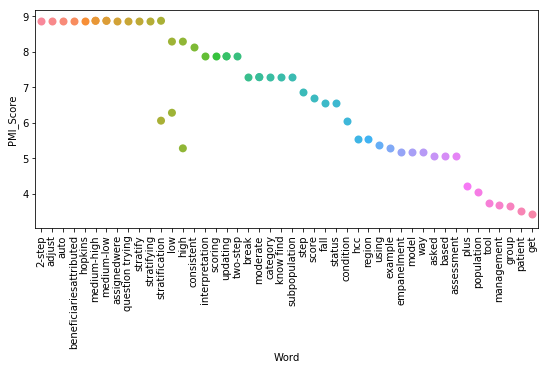

In [73]:
graphing_single_word_finder('risk',mode='single')

TypeError: float() argument must be a string or a number

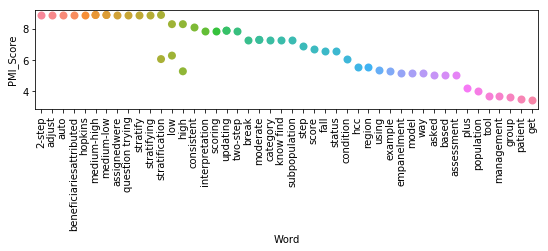

In [74]:
#Hmm can't figure out how to save this for export, was trying to follow this.https://stackoverflow.com/questions/4325733/save-a-subplot-in-matplotlib
full_figure=plt.figure()
saved_fig=full_figure.add_subplot(2,1,2)
saved_fig=saved_fig.plot(graphing_single_word_finder('risk',mode='single'))
saved_fig.savefig('word_correlation_example.png')

In [27]:
graphing_data=single_word_finder('care','','single')
graphing_series=pd.Series(graphing_data)

graphing_series[1][1][1]



6.526488490763201

In [75]:
##Graphing most popular word by day

test_date=top_words['date'][0]

#sns.pointplot(x='date',y='frequency',hue='word',data=top_words)

##okay so this is super busy but we're getting there

#ax.xaxis.set_major_locator(mdates.AutoDateLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))



test_float=float(test_date.month)+(float(test_date.day)/100)

test_float

##There must be a faster/better way to do this

top_words['new_date']=float

for i in xrange(0,len(top_words['date'])):
    top_words['new_date'][i]=float(top_words['date'][i].month)+(float(top_words['date'][i].day)/100)
    


C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



(2.02, 2.3)

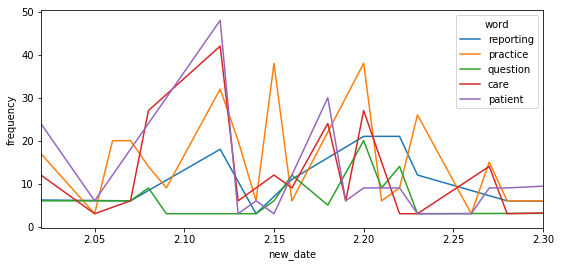

In [76]:
top_words['frequency']=top_words['frequency'].astype(float)

top_words

top_words.dtypes
ax=sns.tsplot(time='new_date',value='frequency',condition='word',unit='word',data=top_words)

#will need to figure out how to do some auto scaling on the plt xlim to get a better view than the default
plt.xlim(2.02,2.3)

## Sentiment Analysis

In [77]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *


nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\583185\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [78]:
sid=SentimentIntensityAnalyzer()
##so this will make a list with all of the sentences analyzed--- compound is the final score ranging from -1 to 1... and then you can get a breakdown of each individual score (how neg/netural/post it is)
##Vader should be the package that we use (formulated for social media results+sweet ass name) but not passing my eye test so far
##if we edit the vader_lexicon.txt file we could add words or change the weighting...
##only would need the token and a score... doesn't use the list of ratings or the standard deviation
##suggested adds-- question should be negative... figure also
##but could you do this on a script basis-- can't have everyone doing this manually
listed_sents=final_report['Body'].tolist()
all_sents=[]
for sentence in listed_sents:
    print(sentence)
    ss=sid.polarity_scores(sentence)
    all_sents.append(ss)
    for i in sorted(ss):
        print(i,ss[i])


CPC+ PRACTICE PORTAL OUTAGE ALERT: Today, Thursday, April 5th 9:00 pm ET to 10:00 pm ET.

Plan ahead! Due to maintenance, the CPC+ Practice Portal will be offline Today, Thursday, April 5th 9:00 pm ET to 10:00 pm ET.
Thank you for your patience during this brief outage.

('compound', 0.6399)
('neg', 0.029)
('neu', 0.862)
('pos', 0.11)
Our practice has not yet received an email regarding our care delivery reporting results. Am I missing something ? Has anyone else not received their performance results? Will we get one regardless?
('compound', 0.3695)
('neg', 0.065)
('neu', 0.825)
('pos', 0.11)
Hi All! Would someone kindly clarify how the performance rate for the CMS138v6 (Tobacco Use Screening and Cessation Intervention) will be calculated?  I recognize this is a multi-strata measure; however, is only one stratum to be used for our final performance.  If so, which is this stratum and what would be the equivalent NQF0028 version? Any clarification would be very helpful.
('compound', 0.7


('compound', 0.8906)
('neg', 0.035)
('neu', 0.721)
('pos', 0.244)
Have you registered for the CPC+ Audit Overview webinar,TODAY? This webinar will provide CPC+ participating practices an overview of the CPC+ audit program. Information will be provided on who will conduct the audits, when audits will occur, and what the audits will evaluate.

('compound', 0.0)
('neg', 0.0)
('neu', 1.0)
('pos', 0.0)
My primary care offices are part of track 2. We have a nurse navigator in each of our offices that follow high risk patients, transitions of care and ED follow ups, as for other case management items. We have been asked about also taking on a nurse call line to help decrease ED and stat care visits. My question is: do any of you utilize your nurses for a call line, or do any of you utilize a nurse call line company?
('compound', 0.8807)
('neg', 0.024)
('neu', 0.835)
('pos', 0.141)
Hello,
Does anyone have a hypertension self management support tool they would be willing to share with us.  tha

('compound', 0.504)
('neg', 0.0)
('neu', 0.954)
('pos', 0.046)
Has anyone noticed that page 136-139 of the 2018 CPC+ Implementation Guide seem to be out of place? 
Care Delivery Reporting starts on page 130 and then at page 136 it jumps to eCQM Overview, then back to reporting on page 140.
Just a heads up!
('compound', 0.5411)
('neg', 0.0)
('neu', 0.926)
('pos', 0.074)
Are there any plans to updatethe Breast Cancer Screening (CMS125v6) criteria for allowing 3D mammography to count as a screening option? We have found that the specialists in some medical neighborhoods only offer 3D instead of2D. Ultimately, our patients' care and health outcomes are still being served through the 3D mammography.

The most recent information I have found related to this question is from "CPC+ 2018 eCQMs: Highlights and Changes from 2017":

"Several practices and vendors have asked whether receiving 3-D mammography will include patients in the numerator. According to the measure steward, this screen by it

('neg', 0.0)
('neu', 1.0)
('pos', 0.0)
Do we need to notify anyone if we can't make it to the NJ regional meeting on Thursday? My intent is to attend, however that is weather dependent, especially when the commute averages 2+ hours without snow or ice.
('compound', 0.0)
('neg', 0.0)
('neu', 1.0)
('pos', 0.0)
Join us for the eCQM Reporting Live Q&A Chat on CPC+ Connect

Still have eCQM reporting questions? Join us for a live Q&A chat on CPC+ Connect this Thursday, February 22, 2018 from 3:00 to 4:00 pm ET. Join the ?CPC+ Connect Live Q&A? group on CPC+ Connect before the session begins to post questions and see responses. Check out the quick tips below to learn how to get the most out of this event.

Please note: The CPC+ Connect Live Q&A group will open on Tuesday, February 20 after 3:00 pm ET; however, it will not be monitored until 3:00 pm on February 22.

('compound', 0.8146)
('neg', 0.0)
('neu', 0.914)
('pos', 0.086)
When CPC+ is asking for 95% empanelment, can you clarify this def

('neg', 0.039)
('neu', 0.735)
('pos', 0.226)
REPOST:

It has come to our attention that there are two small errors in the Practice Feedback Reports recently uploaded to the Practice Portal. Please refer to the attached Addendum, which addresses the errors. If you have further questions, please contact the CPC+ Support team. Thank you for your flexibility!

('compound', 0.7712)
('neg', 0.08)
('neu', 0.713)
('pos', 0.207)
Check out this week?s edition of On the Plus Side for CPC+ information, resources and tools!

This week use new QPP lookup tools to figure out your APM status,read an announcement about Q1 payments, learn how to share your story at the National Meeting and much more!

('compound', 0.4184)
('neg', 0.0)
('neu', 0.943)
('pos', 0.057)
We understood from "On The Plus Side" that the Beneficiary Attribution Reports for Q1-2018 would be available today, but I don't see them. Do we have an update on this? Thanks so much.

('compound', 0.7658)
('neg', 0.0)
('neu', 0.819)
('pos', 

('neu', 0.828)
('pos', 0.141)
Has anyone that uses Intergy heard anything about the issues with the QRDA III file?
I have a ticket in, but support acted like they knew nothing about the issue.

('compound', 0.7783)
('neg', 0.0)
('neu', 0.793)
('pos', 0.207)
Is anyone from the ohio region contracted with Aetna, or has information on Aetna as a payer partner?

('compound', 0.0)
('neg', 0.0)
('neu', 1.0)
('pos', 0.0)
Can you share which psychosocial assessment tool you are using - with the plus' and minus' of the tool. Thanks.

('compound', 0.6249)
('neg', 0.0)
('neu', 0.769)
('pos', 0.231)
I have reviewed my debits list for 8 practices and CMS data states they received CCM services as the reason for the debit most of mine appear to be because the patient is deceased and no CCM services were delivered. Is it possible to identify where the patient received these services? Aslo can someone check into the fact that these may have been errounously tagged as CCM but it was done in error? It is

('neg', 0.0)
('neu', 1.0)
('pos', 0.0)
REMINDER: Practices will have until this Friday, January 26 at 11:59 pm ET to complete both Quarter 4 (Q4) care delivery reporting and financial reporting. Practices that do not complete either financial reporting or care delivery reporting by the close of the extension period will be subject to remedial action by CMS.

('compound', 0.7506)
('neg', 0.0)
('neu', 0.884)
('pos', 0.116)
Are you a Track 2 practice that uses Practice Partners as your health IT vendor? Vendors are hosting capability and collaboration affinity groups. Capability Affinity Group Meetings provide an opportunity for Track 2 practices to interact directly with this vendor on topics related to Track 2 health IT requirements. You can join an affinity group meeting by searching for your HIT vendor?s name in the ?Groups? tab requesting to join your vendor?s group.

('compound', 0.7998)
('neg', 0.0)
('neu', 0.89)
('pos', 0.11)
Does anyone know the approximate time we will get our C

('pos', 0.152)
Did you miss part one of the Care Delivery Orientation Series: Access and Continuity? Click on the link below to learn about how a fellow CPC+ practice has succeeded in implementing these important Care Delivery requirements, improving patient satisfaction and practice performance!

('compound', 0.937)
('neg', 0.03)
('neu', 0.646)
('pos', 0.323)
Interested in using data to reduce emergency department visits? 
Click the link below to check out CPC+ Spotlight 8! This practice spotlight focuses onFamily Practice Associates efforts in using data to reduce emergency department visits in their medical community.

('compound', -0.4199)
('neg', 0.124)
('neu', 0.815)
('pos', 0.061)
Join us, TODAY at 4 PM- 5 PM ET, for the second webinar in the five-part series, Care Delivery Orientation Series: Care Management.Today's webinar willdescribe the primary care function of Care Management and discuss foundational concepts, including longitudinal and episodic care management and risk st

In [79]:
#assign a netural/negative/positive to the final report
#THIS IS COMPLETLEY ARBITRARY, I was going to use the max score for each dictionary entry, but most of them were netural.. using compound in stead

final_report['sentiment']=str
final_report['sentiment_score']=int

for i in range(0,len(all_sents)):
    final_report['sentiment_score'].iloc[i]=all_sents[i]['compound']
    if(all_sents[i]['compound']<-.3):
        final_report['sentiment'].iloc[i]= "negative"
    elif(all_sents[i]['compound']>.3):
        final_report['sentiment'].iloc[i]="positive"
    else:
        final_report['sentiment'].iloc[i]="neutral"
        

C:\Users\583185\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [80]:
sentiment_list=['Body','sentiment','sentiment_score']

sentiment_report=final_report[sentiment_list]



print("percentage of netural sentences=",float(len(sentiment_report[sentiment_report['sentiment']=='neutral']))/float(len(sentiment_report)),"percent of positive sentences=",float(len(sentiment_report[sentiment_report['sentiment']=='positive']))/float(len(sentiment_report)),"percent of negative sentences=",float(len(sentiment_report[sentiment_report['sentiment']=='negative']))/float(len(sentiment_report)))

('percentage of netural sentences=', 0.24719101123595505, 'percent of positive sentences=', 0.6696629213483146, 'percent of negative sentences=', 0.08314606741573034)


In [81]:
##Pie Graph

init_notebook_mode(connected=True)


labels=['Neutral','Positive','Negative']
values=[(len(sentiment_report[sentiment_report['sentiment']=='neutral'])),(len(sentiment_report[sentiment_report['sentiment']=='positive'])),(len(sentiment_report[sentiment_report['sentiment']=='negative']))]

sentiment_pie=go.Pie(labels=labels,values=values)

offline.iplot([sentiment_pie],filename='sentiment pie')

## Topic Modeling

In [35]:
final_report.shape

(199, 12)

In [36]:
token_list = final_report['Body'].map(tokenizer)

# get dictionary for the corpus
corp_dict = corpora.Dictionary(token_list)

# filter down dictionary
corp_dict.filter_extremes(no_below=4, no_above=0.5, keep_n=100000, keep_tokens=None)
corp_dict.compactify()  # remove gaps in id sequence after words that were removed
print(corp_dict)

Dictionary(329 unique tokens: [u'caregiver', u'code', u'help', u'office', u'action group']...)


In [37]:
corpus_master = [corp_dict.doc2bow(token) for token in token_list]

In [38]:
k = 125  # number of topics
min_prob = 0.2  # controls filtering the topics returned for a document
lda = models.LdaModel(corpus_master, id2word=corp_dict, num_topics=k, passes=5, minimum_probability=min_prob)

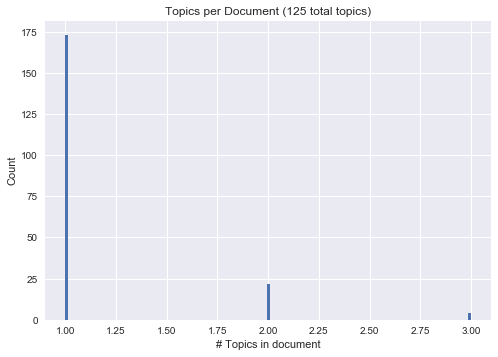

In [39]:
def plot_topics_per_doc(model, corpus, k):
    plt.style.use('seaborn')
    n_topics = []
    for doc in corpus_master:
        n_topics.append(len(lda.get_document_topics(doc)))
    n_topics
    
    plt.title('Topics per Document (' + str(k) + ' total topics)')
    plt.xlabel('# Topics in document')
    plt.ylabel('Count')
    plt.hist(n_topics, bins=k)
    plt.show()
    
plot_topics_per_doc(lda, corpus_master, k)

In [40]:
import operator

# returns DataFrame with topics and # of documents they appear in, sorted most to fewest
def get_topic_freq(lda, corpus):
    topic_counts = dict.fromkeys(range(k), 0)
    for doc in corpus:
        for topic in lda.get_document_topics(doc):
            topic_counts[topic[0]] += 1
    return pd.DataFrame(sorted(topic_counts.items(), key=operator.itemgetter(1), reverse=True), columns=['Topic', 'n_docs'])

# plot a sorted, horizontal bar chart of top topics
def plot_top_topics(lda, topic_freq, n):
    plt.style.use('seaborn')
    top = topic_freq[:n]
    if (n>25):
        plt.figure(figsize=(20, 22))
        plt.rcParams.update({'font.size': 40})
        plt.yticks(range(n), [[x[0] for x in lda.show_topic(t)] for t in top['Topic']], fontsize = 20)
    else:
        plt.yticks(range(n), [[x[0] for x in lda.show_topic(t)] for t in top['Topic']])
    plt.barh(range(n), top['n_docs'])
    
    plt.gca().invert_yaxis()
    plt.title('Top ' + str(n) +' topics')
    plt.xlabel('# documents containing topic')
    
    plt.show()

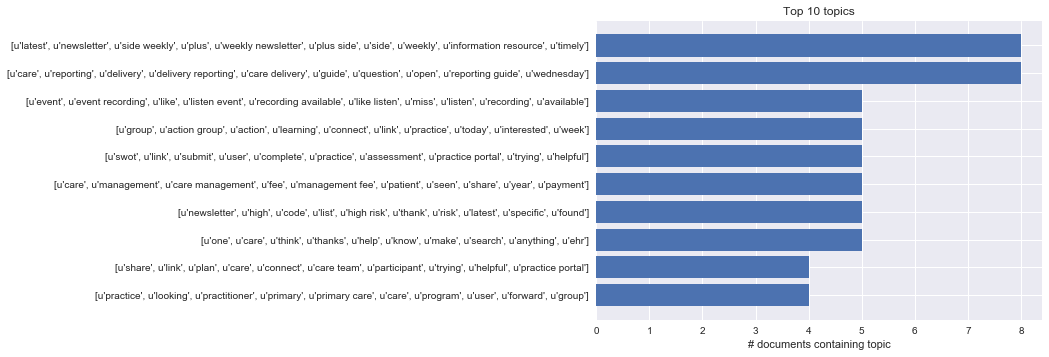

In [41]:
topic_freq = get_topic_freq(lda, corpus_master)
plot_top_topics(lda, topic_freq, 10)

In [42]:
def assign_topic_to_doc(lda, corpus, report):
    i= 0
    report['Topic'] = "NA"

    for doc in corpus:
        doc_topic = lda.get_document_topics(doc)[0][0]
        topic_list = []
        for x in lda.show_topic(doc_topic):
            topic_list.append(x[0])
        report['Topic'].iloc[i] = topic_list
        i += 1
    return report


In [43]:
topics_report = assign_topic_to_doc(lda, corpus_master, final_report)

In [44]:
topics_report.head(5)

,Network: Name,Name,Created By: Full Name,Created By: Company Name,Body,Created Date,Like Count,Comment Count,Feed Item Type,tokens,sentiment,sentiment_score,Topic
23,CPC Plus Connect,CPC+ All,Jon Regis,NJ,does everyone have portal access\n,2017-02-02,2.0,47.0,Text Post,"[portal, access, portal access]",neutral,0,"[access, practice, portal, medicare, able, pra..."
24,CPC Plus Connect,CPC+ All,Stephanie Hardin,OH,I am trying to figure out how to document/trac...,2017-02-03,11.0,34.0,Text Post,"[trying, figure, document/track, use, cmf, pay...",positive,0.5204,"[required, use, additional, wondering, cmf, an..."
25,CPC Plus Connect,CPC+ All,Sam Gottuso,BAH,We appreciate your participation in the Care M...,2017-02-03,2.0,4.0,Content Post,"[appreciate, participation, care, management, ...",positive,0.7096,"[webinar, recording, next week, slide, downloa..."
26,CPC Plus Connect,CPC+ All,Juliana Fritschel,CO,How is a group created within CPC+ Connect? I ...,2017-02-03,1.0,0.0,Text Post,"[group, created, within, connect, saw, post, t...",positive,0.75,"[group, start, created, post, connect, within,..."
27,CPC Plus Connect,NLT Internal Users,Bridget Lalley Ryder,NaN,Attention all CPC+ practices! Are there other ...,2017-02-03,0.0,0.0,Link Post,"[attention, practice, payer, region, partnerin...",positive,0.6939,"[payer, cm, practice, survey, u, like, give, r..."


In [45]:
topics_report.to_excel('output.xlsx')

ImportError: No module named openpyxl

In [ ]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

pyLDAvis.enable_notebook() 
pyLDAvis.gensim.prepare(lda, corpus_master, corp_dict, mds='mmds')
#pyLDAvis.display(vis_data)

In [ ]:
lda.print_topic(1,topn=10)